In [20]:
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack

def create_rule_based_sparse_matrix(df, n_bins=5, encode='onehot', strategy='quantile'):
    # Initialize the KBinsDiscretizer
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
    sparse_matrix = discretizer.fit_transform(df)
    bin_edges = discretizer.bin_edges_

    # Create new sparse matrices for each rule type
    greater_matrix = csr_matrix((0, sparse_matrix.shape[1]))
    greater_equal_matrix = csr_matrix((0, sparse_matrix.shape[1]))
    less_matrix = csr_matrix((0, sparse_matrix.shape[1]))
    less_equal_matrix = csr_matrix((0, sparse_matrix.shape[1]))

    # Fill rule-based matrices
    for i in range(sparse_matrix.shape[0]):  # Iterate over each row
        row = sparse_matrix.getrow(i)
        for j in range(len(bin_edges) - 1):  # Iterate over each bin edge
            # Create new rows for each type of rule
            greater_row = (row > bin_edges[j+1]).astype(int)
            greater_equal_row = (row >= bin_edges[j]).astype(int)
            less_row = (row < bin_edges[j]).astype(int)
            less_equal_row = (row <= bin_edges[j+1]).astype(int)

            # Stack rows vertically in corresponding matrices
            greater_matrix = vstack([greater_matrix, greater_row])
            greater_equal_matrix = vstack([greater_equal_matrix, greater_equal_row])
            less_matrix = vstack([less_matrix, less_row])
            less_equal_matrix = vstack([less_equal_matrix, less_equal_row])

    # Combine all rule matrices horizontally
    combined_matrix = hstack([greater_matrix, greater_equal_matrix, less_matrix, less_equal_matrix])

    return combined_matrix

In [21]:
from scipy.sparse import csr_matrix

def combine_rules(data_matrix, indices):
    """
    Combine rules specified by indices using logical AND via matrix operations.

    Args:
        data_matrix (csr_matrix): Sparse matrix where each column represents a rule.
        indices (list of int): List of column indices to combine.

    Returns:
        np.array: Combined rule as an array of 0s and 1s.
    """
    if not indices:
        raise ValueError("Indices list is empty.")

    # Initialize the combined rule with the first rule's data
    combined_rule = data_matrix[:, indices[0]].toarray()

    # Multiply subsequent rule columns to apply logical AND
    for idx in indices[1:]:
        combined_rule = combined_rule * data_matrix[:, idx].toarray()

    return combined_rule.ravel()  # Flatten the array to 1D


def calculate_woe(combined_rule, y):
    total_goods = np.sum(y == 1)
    total_bads = np.sum(y == 0)
    goods = np.sum(combined_rule[y == 1])
    bads = np.sum(combined_rule[y == 0])
    good_ratio = max(goods / total_goods, 1e-10)
    bad_ratio = max(bads / total_bads, 1e-10)
    woe = np.log(good_ratio / bad_ratio)
    return woe


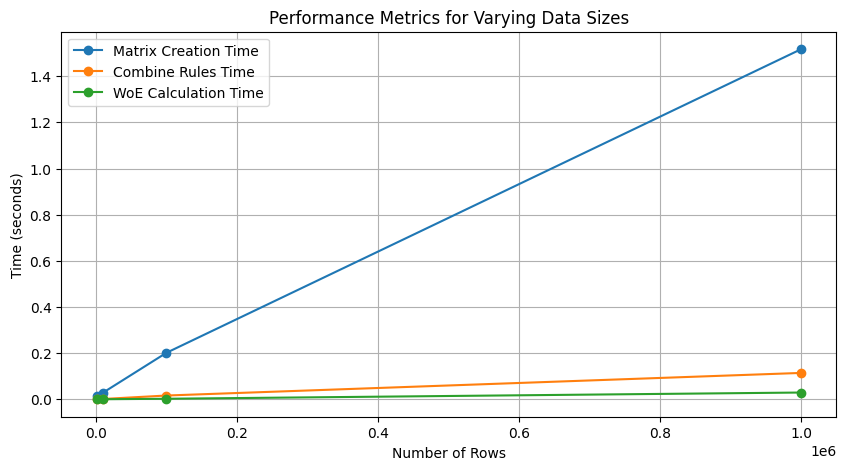

In [22]:
import matplotlib.pyplot as plt
import time

def create_large_test_dataframe(num_rows, num_features):
    # Create large DataFrame with random numbers
    data = {f'feature_{i}': np.random.rand(num_rows) for i in range(num_features)}
    df = pd.DataFrame(data)
    return df

import matplotlib.pyplot as plt
import time

def performance_measurement(num_rows, num_features):
    df = create_large_test_dataframe(num_rows, num_features)

    # Measure time to create sparse binary matrix
    start_time = time.time()
    sparse_matrix = create_sparse_binary_matrix(df)
    matrix_time = time.time() - start_time

    # Assume a random target vector
    y = np.random.randint(0, 2, num_rows)

    # Measure time to combine rules
    indices = [0, 1]  # Example: combining the first two features
    start_time = time.time()
    combined_rule = combine_rules(sparse_matrix, indices)
    combine_time = time.time() - start_time

    # Measure time to calculate WoE
    start_time = time.time()
    woe_value = calculate_woe(combined_rule, y)
    woe_time = time.time() - start_time

    return matrix_time, combine_time, woe_time

def plot_performance(rows):
    features = 10  # Constant number of features
    results = [performance_measurement(n, features) for n in rows]
    matrix_times, combine_times, woe_times = zip(*results)

    plt.figure(figsize=(10, 5))
    plt.plot(rows, matrix_times, label='Matrix Creation Time', marker='o')
    plt.plot(rows, combine_times, label='Combine Rules Time', marker='o')
    plt.plot(rows, woe_times, label='WoE Calculation Time', marker='o')
    plt.xlabel('Number of Rows')
    plt.ylabel('Time (seconds)')
    plt.title('Performance Metrics for Varying Data Sizes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example test sizes
rows = [1000, 10000, 100000, 1000000]  # Different number of rows
plot_performance(rows)